# Cross-validation of DAVE and Orcaflex Hydrostatics

Build a scene with the example barge ballasted down to 4m draft

In [3]:
from DAVE import *
s = Scene('100x30x8_barge.dave')

s.goal_seek(evaluate="s['Barge'].z",
    target=-4.0,
    change_property="mass",
    change_node="Barge")

s.solve_statics()

Loading c:\python\miniconda3\envs\book\lib\site-packages\DAVE\resources\100x30x8_barge.dave
Attempting to evaluate s['Barge'].z to -4.0 (now 0.0)
By changing the value of Barge.mass (now 5000.0)
setting 5000.0 results in -1.626016260162603
setting 5000.0001 results in -1.6260162926829276
setting 12300.000123871137 results in -4.0000000402832985
      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 12299.999999999996
Solved to 9.313225746154785e-10.


c:\python\miniconda3\envs\book\lib\site-packages\DAVE\scene.py:3579: UserWarning: BallastSystem.new_tank is outdated and may be removed in a future version.
  "BallastSystem.new_tank is outdated and may be removed in a future version."


True

Show the model

No actors created for node Barge Ballast system


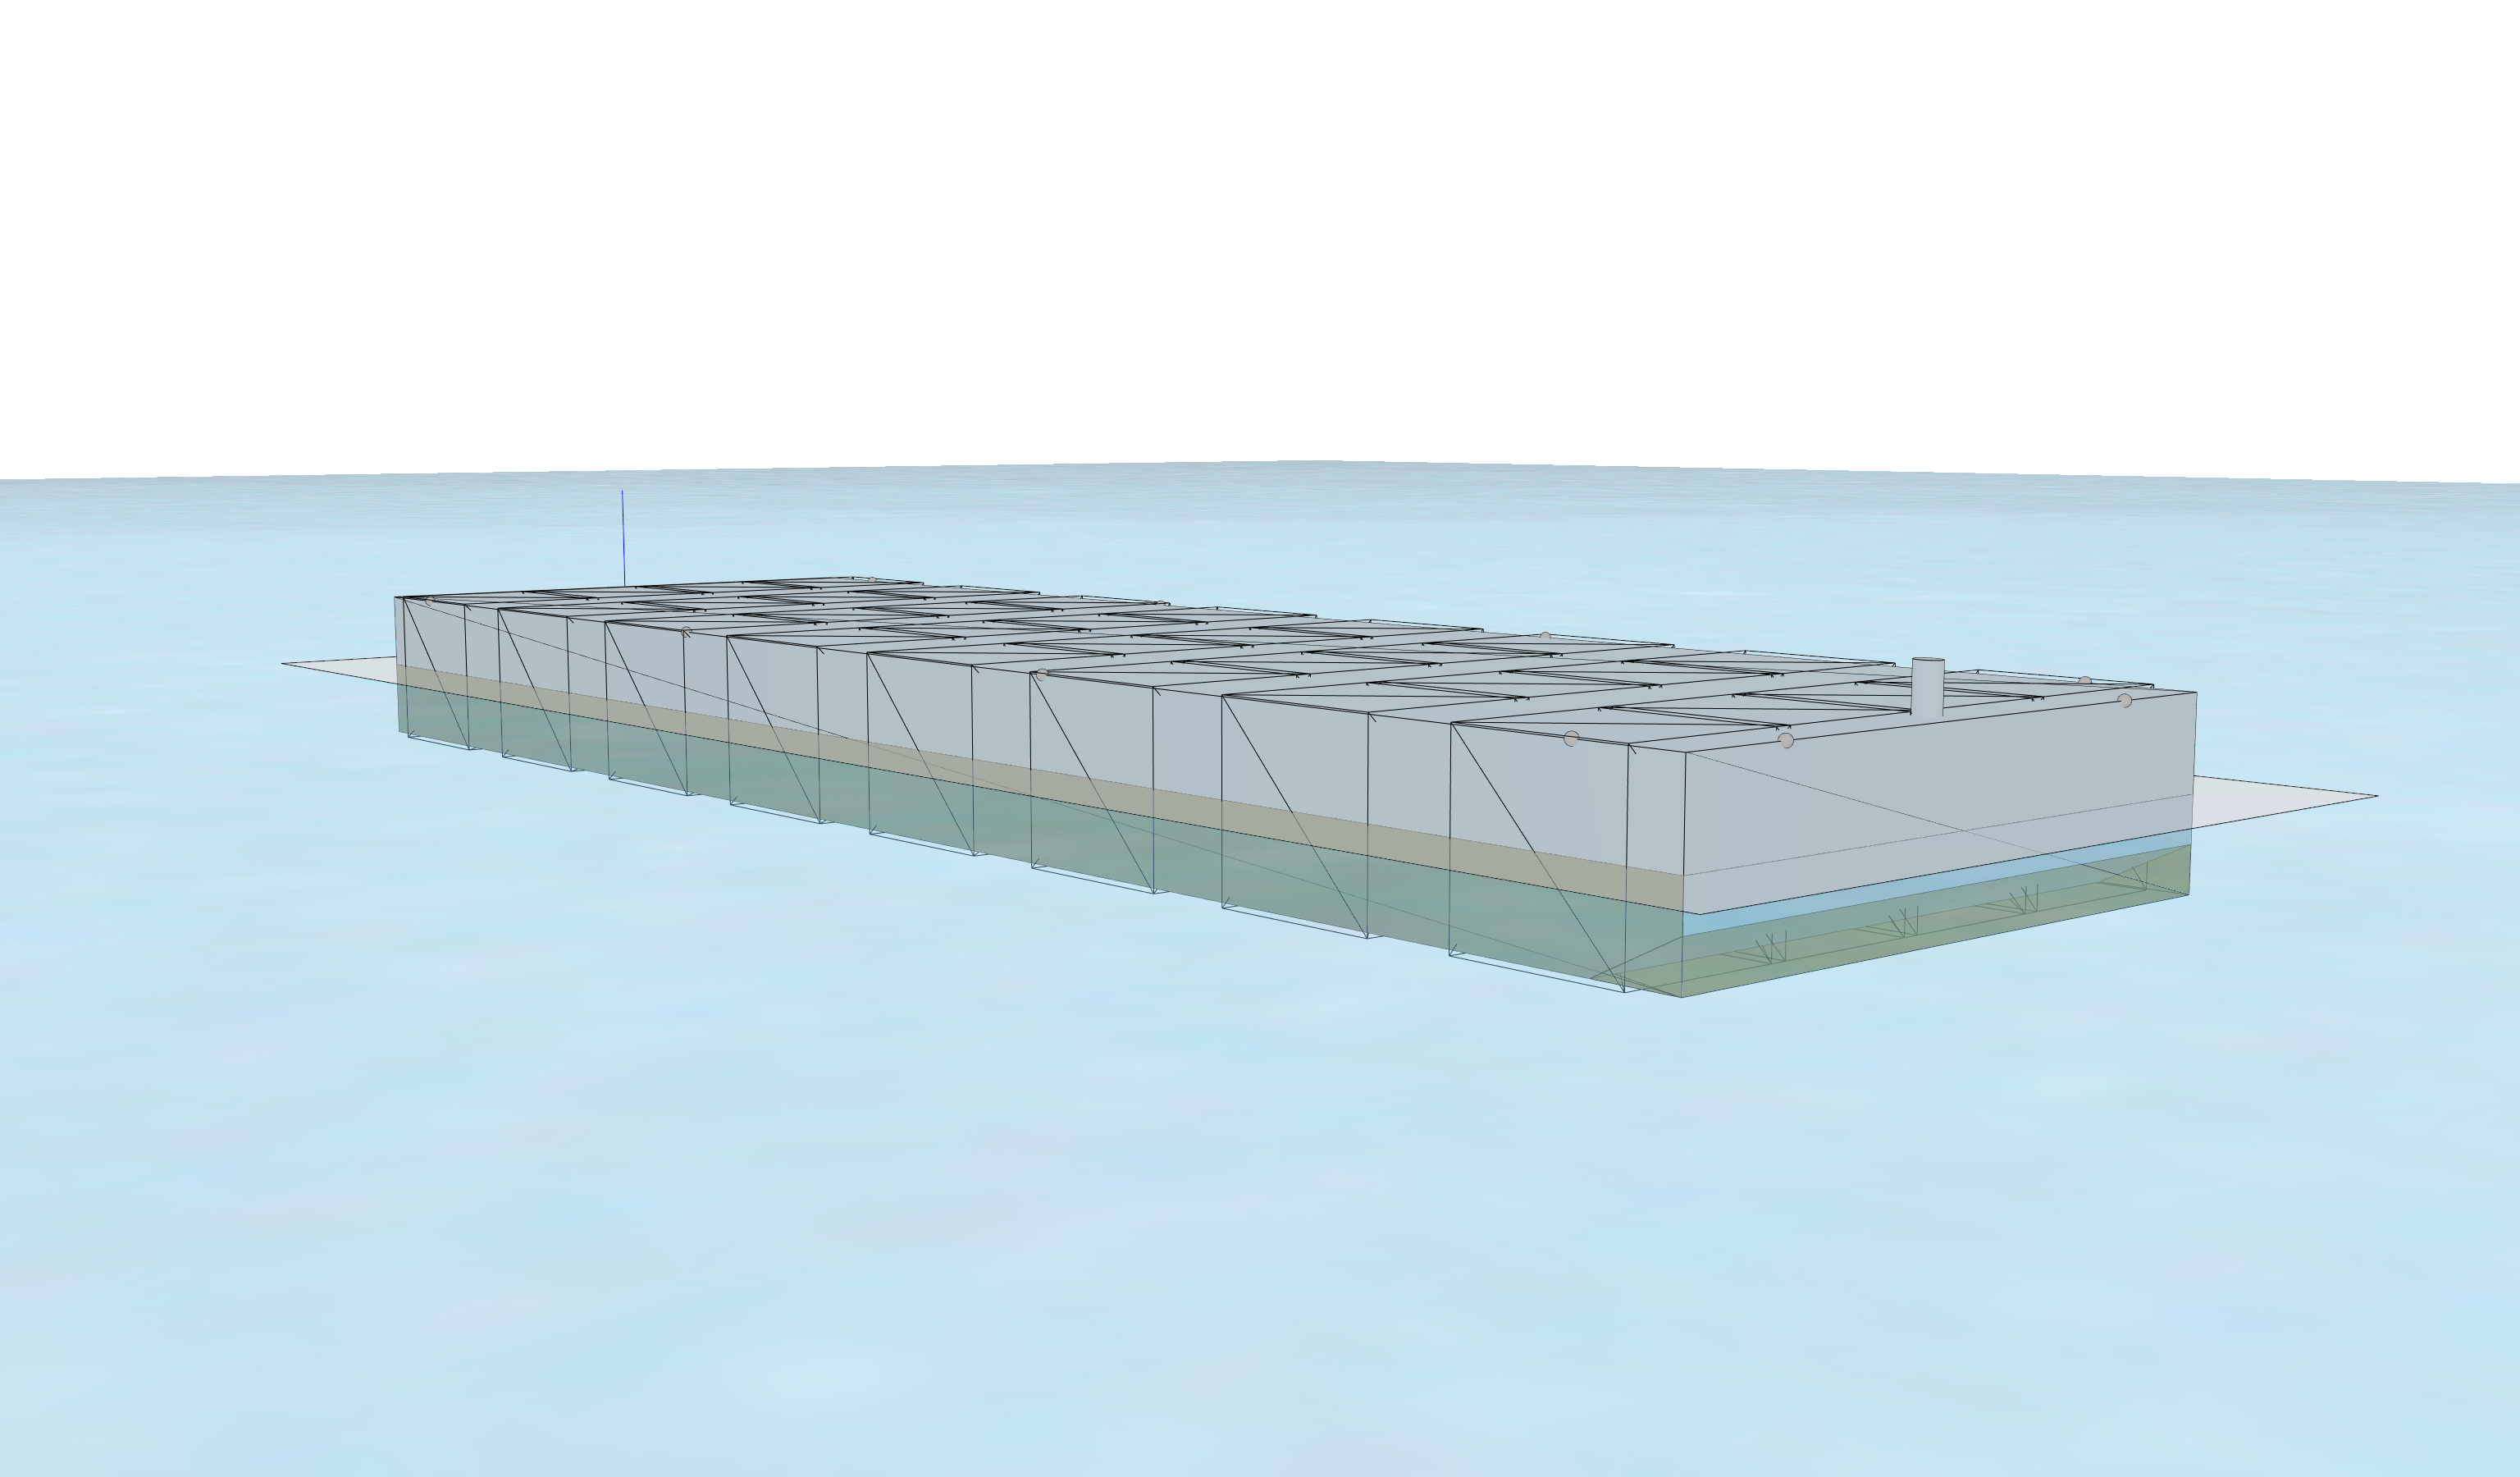

In [4]:
from DAVE.jupyter import *
show(s, show_global = True, camera_pos = (158.99328689012356, -83.11396799310523, 14.821261537388635), lookat = (18.24840759806191, 36.62760209655524, -6.699510976000989), force_do_normalize= True, force_scale = 1.6, cog_scale = 0.25)

In [5]:
# view(s)  # for interactive view

The buoyancy of the model comes from a buoyancy mesh. Unfortunately Orcaflex does not support meshes as buoyancy objects. 

The DAVE.marine package provides a function to create a linearized buoayncy node (HydSpring) from a buoyancy shape.

In [6]:
from DAVE.marine import *
linearize_buoyancy(s, s['Buoyancy mesh'])


Buoyancy mesh <HydSpring>

The buoyancy mesh node has now been replaced with a HydSpring node. Confusingly with the same name...

In [7]:
node = s['Buoyancy mesh']
type(node)

DAVE.scene.HydSpring

Lets give is another name and report its properties

In [8]:
node.name = "Linear buoyancy"
report(node)


Property,Value,Unit,Remarks,Explained
name,Linear buoyancy,,str,"Name of the node , must be unique"
cob,"(50.000, -0.000, 2.000 )",,"m,m,m",Center of buoyancy in parent axis system
BMT,18.752,m,,Vertical distance between cob and metacenter for roll
BML,208.335,m,,Vertical distance between cob and metacenter for pitch
COFX,0.000,m,center of waterplane area,"Horizontal x-position Center of Floatation , relative to cob"
COFY,0.000,m,center of waterplane area,"Horizontal y-position Center of Floatation , relative to cob"
kHeave,30155.449,kN/m,,Heave stiffness
waterline,2.000,m,which is where is normally is,Waterline-elevation relative to cob for un-stretched heave-spring. Positive if cob is below the waterline
displacement_kN,120621.796,kN,,Displacement when waterline is at waterline-elevation
name,Linear buoyancy,,str,"Name of the node , must be unique"


And lets double-check that it does not affect the equilibrium position of the barge, it should still be at -4.000 m and even-keel:

In [9]:


s.solve_statics()

report(s['Barge'],['global_position','heel','trim'])

Solved to 9.313225746154785e-10.


Property,Value,Unit,Remarks,Explained
global_position,"(0.000, 0.000, -4.000 )","m,m,m",global axis,The global position of the origin of the axis system
heel,0.000,deg,,Heel in degrees. SB down is positive .
trim,0.000,deg,,Trim in degrees. Bow-down is positive .


## Add cargo

Add an cargo module on the barge. Check the induced heel and trim

In [10]:
s.new_rigidbody('Cargo',parent='Barge', position = (10, 30, 20), mass = 500)

Cargo <RigidBody>

In [11]:
s.solve_statics()

report(s['Barge'],['global_position','heel','trim'])

Solved to 2.523884177207947e-07.


Property,Value,Unit,Remarks,Explained
global_position,"(0.000, 0.000, -4.547 )","m,m,m",global axis,The global position of the origin of the axis system
heel,-4.617,deg,,Heel in degrees. SB down is positive .
trim,-0.455,deg,,Trim in degrees. Bow-down is positive .


## Orcaflex

This model can be exported to an orcaflex .yml model file.

In [12]:
from DAVE.io.orcaflex import *

export_ofx_yml(s,'barge_heel_trim.yml')

c:\python\miniconda3\envs\book\lib\site-packages\mafredo\hyddb1.py:265: UserWarning: Guessing symmetry for c:\python\miniconda3\envs\book\lib\site-packages\DAVE\resources\barge_100_30_4.dhyd to be XZ (PS/SB) because maximum heading = 180.0 deg
  f"Guessing symmetry for {filename} to be XZ (PS/SB) because maximum heading = {max_dir} deg"


created barge.obj
created barge_heel_trim.yml


c:\python\miniconda3\envs\book\lib\site-packages\DAVE\io\orcaflex.py:142: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eu = total.as_euler(seq='xyz', degrees=True).tolist()


Now it is possible that you, like me, do not have orcaflex. You can still download the orcaflex demo to open and view the .yml model file

![screenshot](screenshot_barge.png)

Now there is some explaining to do on how exactly this was exported.

The hydrodynamics are easy: the first order wave forces, added mass and damping were exported to the vessel-type.

The hydrostatics are a bit more complex, but in a nice way.

The mass of the vessel is exported as a 6D buoy. This 6D buoy is then connected to the vessel.
The buoyancy of the vessel is exported to the vessel type. This means that the mass of the vessel-type is set to almost zero. The effect of that is that the stiffness matrix of the vessel type, which normally includes the weight components, is reduced to purely the hydrostatic matrix. So based on KM, not KG. If you have ever tried to model a vessel in orcaflex using different 6D buoys (for example a vessel with a crane) then you will certainly appreciate this method. 

So:
- Hydrodynamics and Buoyancy go into the vessel-type (everything related to water)
- Mass and inertia go into a 6D buoy

---